In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.time import Time

In [63]:
file_path = 'rob_tsi_composite.txt'

tsi_daily = pd.read_csv(file_path, 
                 skiprows=21,  # Skip the header comments
                 sep='\s+',
                 names=['Year', 'TSI_W_m2', 'Julian_Date'])

tsi_daily.head()

,Year,TSI_W_m2,Julian_Date
0,1947.119781,1363.060059,2432231
1,1947.122519,1363.420044,2432232
2,1947.125257,1363.770020,2432233
3,1947.127995,1364.160034,2432234
4,1947.130732,1364.310059,2432235


In [64]:
times = Time(tsi_daily['Julian_Date'], format='jd')
datetime_objects = times.datetime

tsi_daily['Date'] = [d.date() for d in datetime_objects]
tsi_daily = tsi_daily.drop(['Year', 'Julian_Date'], axis=1)

tsi_daily = tsi_daily.set_index('Date')

tsi_daily.head()

/opt/anaconda3/envs/ssn/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 4703 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


,TSI_W_m2
Date,
1947-02-14,1363.060059
1947-02-15,1363.420044
1947-02-16,1363.770020
1947-02-17,1364.160034
1947-02-18,1364.310059


In [73]:
# Convert index to datetime
tsi_daily.index = pd.to_datetime(tsi_daily.index)

# Monthly resampling
tsi_monthly = tsi_daily.resample('ME').mean()

In [74]:
def apply_13month_smooth(series):
    smoothed = pd.Series(index=series.index, dtype=float)
    smoothed[:] = np.nan  # Initialize with NaN
    
    for i in range(6, len(series) - 6):
        window = series.iloc[i-6:i+7].values
        weights = np.ones(13)
        weights[0] = 0.5
        weights[-1] = 0.5
        smoothed.iloc[i] = np.sum(window * weights) / 12  # Fixed normalization
    
    return smoothed

In [75]:
# Create a DataFrame for the 13-month smoothed data
tsi_13_month_smooth = pd.DataFrame(index=tsi_monthly.index)
tsi_13_month_smooth['TSI_W_m2'] = apply_13month_smooth(tsi_monthly['TSI_W_m2'])
tsi_13_month_smooth = tsi_13_month_smooth.dropna()

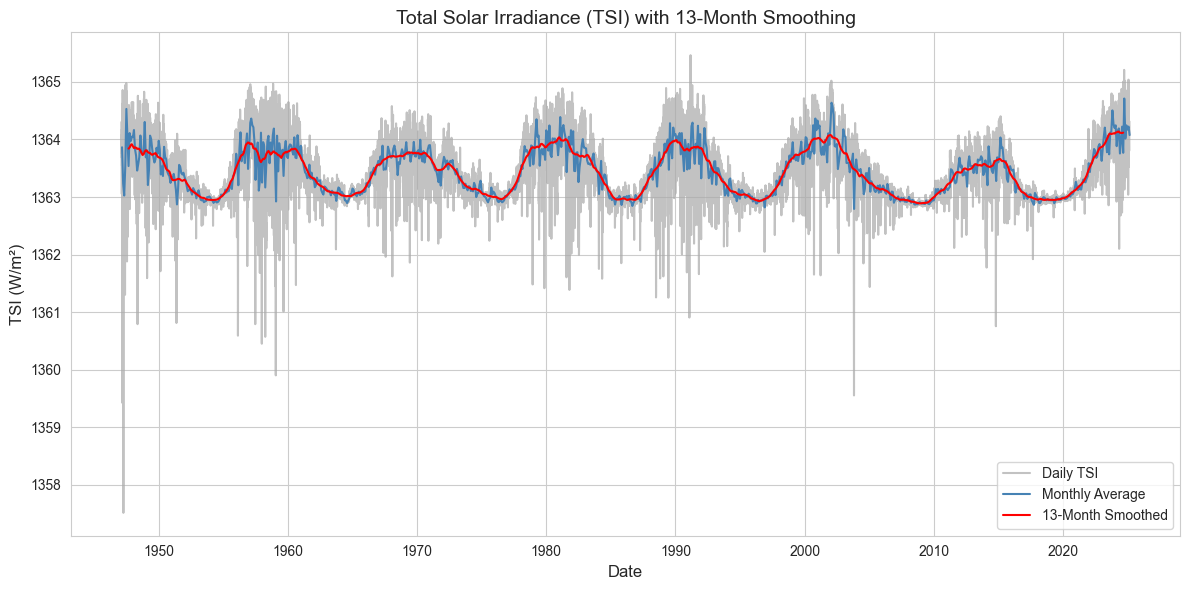

In [76]:
plt.figure(figsize=(12, 6))

# Daily data
plt.plot(tsi_daily.index, tsi_daily['TSI_W_m2'], color='darkgray', alpha=0.7, label='Daily TSI')

# Monthly data
plt.plot(tsi_monthly.index, tsi_monthly['TSI_W_m2'], color='steelblue', label='Monthly Average')

# 13-month smoothed data
plt.plot(tsi_13_month_smooth.index, tsi_13_month_smooth['TSI_W_m2'], color='red', label='13-Month Smoothed')

plt.title('Total Solar Irradiance (TSI) with 13-Month Smoothing', fontsize=14)
plt.ylabel('TSI (W/m²)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

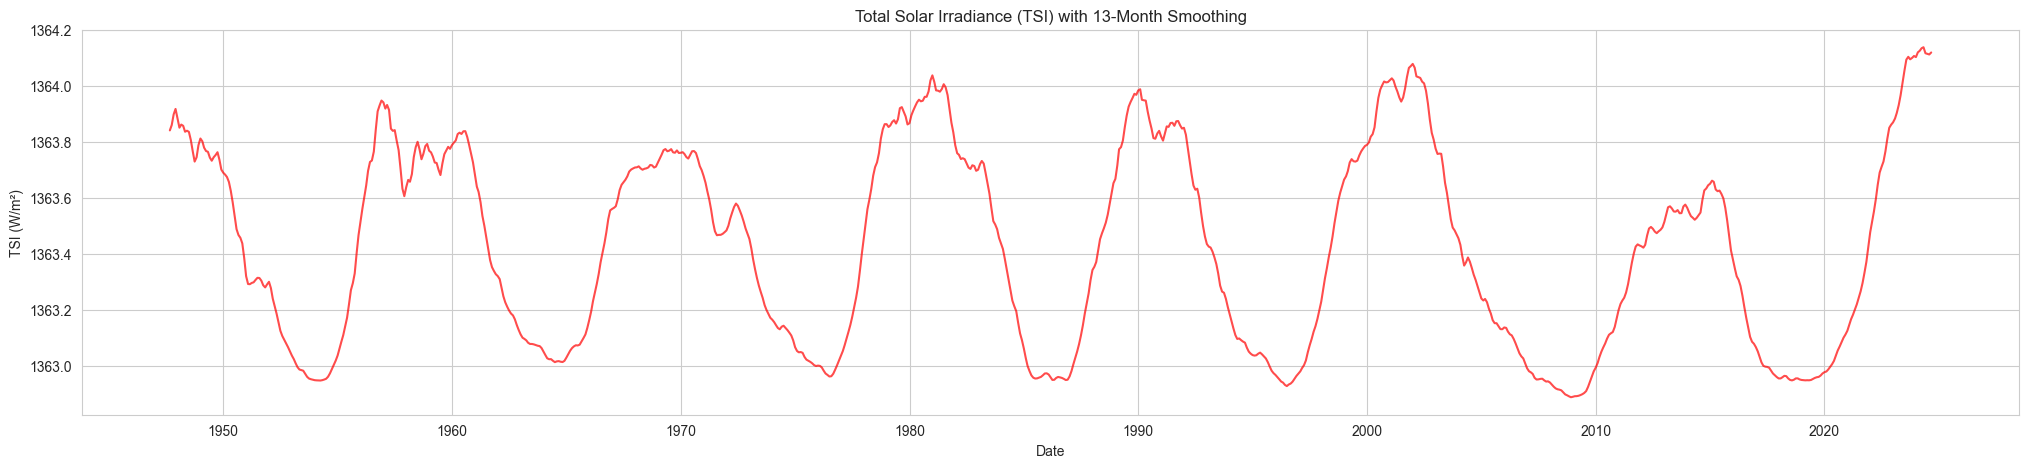

In [77]:
plt.figure(figsize=(25, 5))
plt.xlabel('Date')
plt.ylabel('TSI (W/m²)')
plt.title('Total Solar Irradiance (TSI) with 13-Month Smoothing')
plt.plot(tsi_13_month_smooth.index, tsi_13_month_smooth['TSI_W_m2'], 'r', alpha=0.7)
plt.grid(True)
plt.show()

In [80]:
tsi_13_month_smooth['Year'] = tsi_13_month_smooth.index.year
tsi_13_month_smooth['Month'] = tsi_13_month_smooth.index.month

# Export the data to a CSV file
tsi_year_month = tsi_13_month_smooth[['Year', 'Month', 'TSI_W_m2']].copy()
tsi_year_month = tsi_year_month.reset_index(drop=True)
tsi_year_month.to_csv('tsi_13_month_smoothed.csv', index=False)
tsi_year_month.head()

,Year,Month,TSI_W_m2
0,1947,8,1363.841413
1,1947,9,1363.860329
2,1947,10,1363.898601
3,1947,11,1363.917975
4,1947,12,1363.884501
